# Convolutional Autoencoder

In [1]:
import copy
import torch
import time

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import trange

from util import imshow, plot_sta
from data_process import load_data, write_data

C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [75]:
# data_dir = 'Cat_Dog_data/train'
data_dir = 'data' # load from Kaggle

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((350,851)),
                                torchvision.transforms.ToTensor()
                               ])# TODO: compose transforms here
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform) # TODO: create the ImageFolder
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader




C:\Users\a\AppData\Roaming\Python\Python37\site-packages\torchvision\transforms\transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


KeyError: 851

In [71]:
inputs= iter(dataloaders)
inputs

In [55]:
dataloaders.sampler.data_source.samples.
imshow(dataloaders.sampler)

AttributeError: 'RandomSampler' object has no attribute 'numpy'

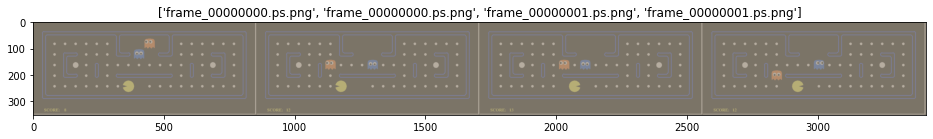

In [72]:
# Get a batch of training data
inputs, classes = next(iter(dataloader))
inputs = inputs[0:4]
classes = classes[0:4]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, classes)

In [73]:
device = torch.device("cuda")
print(torch.cuda.is_available())

True


## Architecture

$H_{out} = \frac{H_{in}+2p-k}{s}+1$

$H_{out} = (H_{in}-1)*s-2p+k$

In [62]:
import torch.nn as nn
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), # 86
            nn.ReLU(True), #
            nn.MaxPool2d(kernel_size=3, stride=2), # 42
            nn.Conv2d(64, 192, kernel_size=5, padding=2),# 42
            nn.ReLU(True),#
            nn.MaxPool2d(kernel_size=3, stride=2), # 20
            nn.Conv2d(192, 384, kernel_size=3, padding=1),# 20
            nn.ReLU(True),#
            nn.Conv2d(384, 256, kernel_size=3, padding=1),# 20
            nn.ReLU(True),#
            nn.Conv2d(256, 256, kernel_size=3, padding=1),# 20
            nn.ReLU(True),# 20
            nn.MaxPool2d(kernel_size=3, stride=2), #
            nn.AdaptiveAvgPool2d((2, 2)), # 2
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='nearest'), # 8
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, (3,3)), # 10
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 384, (3,3), padding=1), # 10
            nn.ReLU(True),
            nn.ConvTranspose2d(384, 192, (3,3), padding=1), # 10
            nn.Upsample(scale_factor=2, mode='nearest'), # 20
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 64, (5,5), stride = 2),  # 43
            nn.Upsample(scale_factor=2, mode='nearest'), # 86
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, (12,12), stride=4, padding=1),  # 350  
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

net = Autoencoder().to(device)

In [63]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [64]:
sta = {'train':{'epoch_loss':[]},'dev':{'epoch_loss':[]}}

In [65]:
para_dict = {}

## Train

In [66]:
best_loss = 50

In [67]:
num_epochs = 50

In [74]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  # Set model to training mode
        else:
            net.eval()   # Set model to evaluate mode

        running_loss = 0.0

        for batch in dataloader:
            
            inputs = batch[0].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, inputs)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]

        # statistics
        sta[phase]['epoch_loss'].append(epoch_loss)
        
        if phase == 'dev':
            print(epoch_loss, time.strftime("%H:%M:%S", time.localtime()))
        if phase == 'dev' and epoch in [0, 2, 4, 6, 9, 29, 49]:
            para_dict[epoch] = copy.deepcopy(net.state_dict())
        if phase == 'dev' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_wts = copy.deepcopy(net.state_dict())

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\a\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([32, 3, 350, 851])) that is different to the input size (torch.Size([32, 3, 350, 350])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (350) must match the size of tensor b (851) at non-singleton dimension 3

In [ ]:
net.load_state_dict(best_wts)

## Result

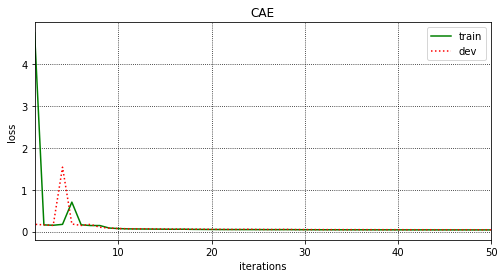

min train loss: 0.04053929945081473
min dev loss: 0.0441849898993969 at epoch 49
corresponding train loss: 0.04068142193555832


In [26]:
fig = plt.figure(figsize=(18, 4))

epochs = len(sta['train']['epoch_loss'])
min_d_loss = min(sta['dev']['epoch_loss'])
min_d_loss_index = sta['dev']['epoch_loss'].index(min_d_loss) + 1

# plot loss
t_loss = sta['train']['epoch_loss']
d_loss = sta['dev']['epoch_loss']
ax = plt.subplot(122)
tlline, = plt.plot(np.append(np.roll(t_loss, 1), t_loss[epochs - 1]), color='g')
dlline, = plt.plot(np.append(np.roll(d_loss, 1), d_loss[epochs - 1]), linestyle=":", color='r')
plt.grid(color="k", linestyle=":")
plt.legend((tlline, dlline), ('train', 'dev'))
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title('CAE')
ax.set_xlim(1, epochs)
plt.show()

print("min train loss: " + str(min(t_loss)))
print("min dev loss: " + str(min_d_loss) + " at epoch " + str(min_d_loss_index))
print("corresponding train loss: " + str(t_loss[min_d_loss_index - 1]))

In [ ]:
torch.save(net.state_dict(), './net/CAE.pt')

## visualization autoencoder

true image

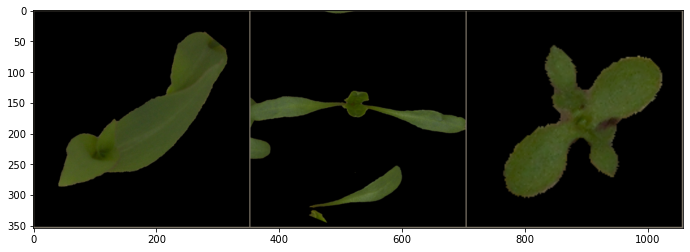

In [27]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:3]
out1 = torchvision.utils.make_grid(inputs)
imshow(out1)

reconstructed image

0.17460418295860292
0.14825732306639353
0.18127068030834198
0.17336639833450318
0.07333119150996208
0.04896430599689484
0.04441322122017542


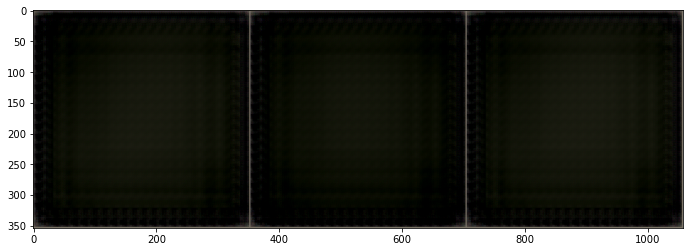

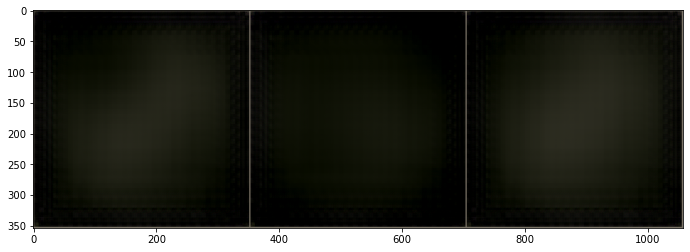

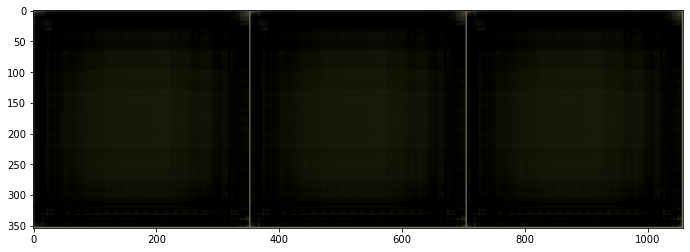

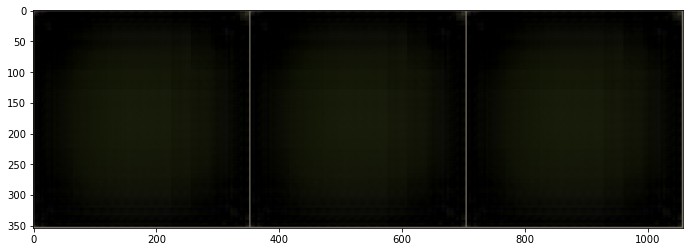

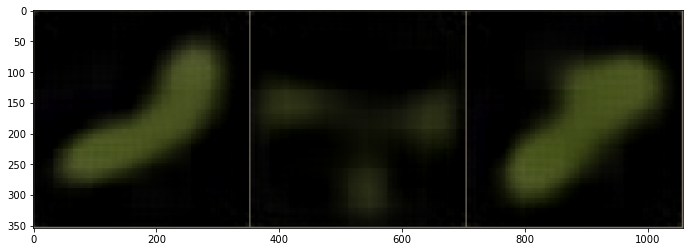

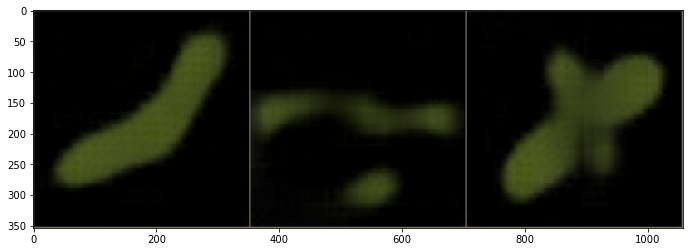

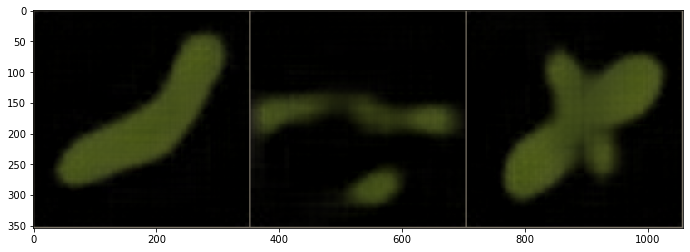

In [28]:
for i in para_dict.keys():
    net.load_state_dict(para_dict[i])
    print(sta['dev']['epoch_loss'][i])
    reconstructed = net(inputs.to(device))
    out = torchvision.utils.make_grid(reconstructed.cpu().detach())
    imshow(out)

In [ ]:
net.name = 'CAE'
path_net = './net/%s.pt'%net.name
torch.save(net.state_dict(), path_net)
path_sta = './figures/%s_sta.pt'%net.name
torch.save(sta, path_sta)

# Classifier

## Architecture

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), # 86
            nn.ReLU(True), #
            nn.MaxPool2d(kernel_size=3, stride=2), # 42
            nn.Conv2d(64, 192, kernel_size=5, padding=2),# 42
            nn.ReLU(True),#
            nn.MaxPool2d(kernel_size=3, stride=2), # 20
            nn.Conv2d(192, 384, kernel_size=3, padding=1),# 20
            nn.ReLU(True),#
            nn.Conv2d(384, 256, kernel_size=3, padding=1),# 20
            nn.ReLU(True),#
            nn.Conv2d(256, 256, kernel_size=3, padding=1),# 20
            nn.ReLU(True),# 20
            nn.MaxPool2d(kernel_size=3, stride=2), #
            nn.AdaptiveAvgPool2d((2, 2)), # 2
        )
        self.fc = nn.Sequential(
            self.fc_block(1024, 512),
            self.fc_block(512, 256),
            self.fc_block(256, 12, final_layer=True)
        )

    def fc_block(self, in_dim, out_dim, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.ReLU(True)
            )
        else:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
            )
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

net = Classifier().to(device)

load the parameters of the trained encoder from the autoencoder

In [ ]:
# showing error is expected since the new network only contains the encoder part
net.load_state_dict(torch.load('./net/CAE.pt'))

## Train

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [ ]:
sta = {'train':{'epoch_acc':[], 'epoch_loss':[]},'dev':{'epoch_acc':[], 'epoch_loss':[]}}

In [ ]:
best_acc = 0

In [ ]:
num_epochs = 20

In [ ]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  
        else:
            net.eval()   

        running_loss = 0.0
        running_corrects = 0

        for batch in dataloaders[phase]:
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.item() / dataset_sizes[phase]

        # statistics recording
        sta[phase]['epoch_acc'].append(epoch_acc)
        sta[phase]['epoch_loss'].append(epoch_loss)

        # show the current dev acc and time
        if phase == 'dev':
            print('{:.3%}'.format(epoch_acc), time.strftime("%H:%M:%S", time.localtime()))
            
        # record parameters of the best net
        if phase == 'dev' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_wts = copy.deepcopy(net.state_dict())

In [ ]:
net.load_state_dict(best_wts)

## Result

In [ ]:
plot_sta(sta)

save net

In [ ]:
torch.save(net.state_dict(), './net/classifer_CAE.pt')

## Write test file

In [ ]:
write_data(net)